In [ ]:
# all shut down to restart kernel
import os
os._exit(00)

# **Environment setting**

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16017310764195365090
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2813160014985074537
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 100368962070401299
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11194091014089711772
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
import os
!ls
%cd /content/drive/Colab/unet
%ls
!pip install imagecodecs

adc.json  drive  sample_data
/content/drive/Colab/unet
data.py                     predict.py              train.py
DIC_seg_model_toy_a4.h5     __pycache__/            unet.py
DIC_seg_ST_model_toy_a4.h5  toy4_logs_with_aug.csv
DIC_track_model_toy_a4.h5   track.py
     |████████████████████████████████| 17.9MB 195kB/s 


# **Code part**

## **train**

In [ ]:
!python3 train.py

## **predict**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from data import get_train_val

# --------------------------------------- #
# Step 1: Load Model and Make Predictions #
# --------------------------------------- #

images, labels = get_train_val(split=0) # train
test_images = get_train_val(data='test')
# plt.imshow(np.squeeze(labels)[0], 'gray')
# plt.show()

model_fname = 'DIC_seg_ST_model_toy_a4.h5'
model = keras.models.load_model(model_fname)

# probs = np.squeeze(model.predict(images[:10]))  # (n, 512, 512, 1)
probs = np.squeeze(model.predict(test_images))

# print(probs.shape)
print(np.amin(probs)) # lowest prob
print(np.amax(probs)) # highest prob

# below is for tracking
# for i, prob in enumerate(probs):
#     # print(f'center {i+1}', prob[256, 256])
#     predict = np.argmax(prob, axis=2)
#     predictions.append(predict)

# predictions = [np.where(prob > 0.34, 1, 0) for prob in probs]

# plt.imshow(predictions[0], 'gray')
plt.imshow(probs[0], 'gray')
plt.show()
print(len(probs))
print(probs.shape)
#print(probs[0])

In [ ]:
model_fname = 'DIC_track_model_toy_a4.h5'
model = keras.models.load_model(model_fname)

# probs = np.squeeze(model.predict(images[:10]))  # (n, 512, 512, 1)
probs_marker = np.squeeze(model.predict(test_images))

# print(probs.shape)
print(np.amin(probs_marker)) # lowest prob
print(np.amax(probs_marker)) # highest prob

# below is for tracking
# for i, prob in enumerate(probs):
#     # print(f'center {i+1}', prob[256, 256])
#     predict = np.argmax(prob, axis=2)
#     predictions.append(predict)

# predictions = [np.where(prob > 0.34, 1, 0) for prob in probs]

# plt.imshow(predictions[0], 'gray')
plt.imshow(probs_marker[0], 'gray')
plt.show()
print(len(probs_marker))
print(probs_marker.shape)
#print(probs_marker)

## **save images**

In [ ]:
import skimage.io as io
import skimage.transform as trans

def save_img(prob_array, save_path, img_num, first_index):
  for i in range(img_num):
    if 0<=i<=9:
      io.imsave(os.path.join(save_path+"t00"+str(i)+"_predict.tif"),prob_array[first_index+i])
    elif 10<=i<=99:
      io.imsave(os.path.join(save_path+"t0"+str(i)+"_predict.tif"),prob_array[first_index+i])
    elif i>=100:
      io.imsave(os.path.join(save_path+"t"+str(i)+"_predict.tif"),prob_array[first_index+i])

save_img(probs,"/content/drive/Colab/",len(probs),0)

# save predictions
save_img(probs,"/content/drive/Colab/predict/s1/",84,0)
save_img(probs,"/content/drive/Colab/predict/s2/",84,84)
save_img(probs,"/content/drive/Colab/predict/s3/",115,168)
save_img(probs,"/content/drive/Colab/predict/s4/",115,283)

save_img(probs_marker,"/content/drive/Colab/predict/m1/",84,0)
save_img(probs_marker,"/content/drive/Colab/predict/m2/",84,84)
save_img(probs_marker,"/content/drive/Colab/predict/m3/",115,168)
save_img(probs_marker,"/content/drive/Colab/predict/m4/",115,283)


## **drawcounter**

### import

global threshold

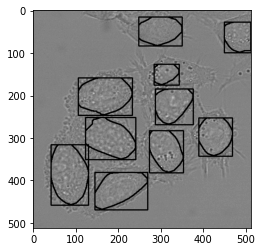

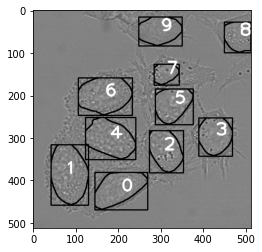

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import io
import skimage.transform as trans

img = cv2.imread('/content/drive/Colab/data/t000.tif',-1)
pre = cv2.imread('/content/drive/Colab/data/t000_predict.tif',-1)

pre_float = np.zeros((512,512),float)
for i in range(512):
  for j in range(512):
    pre_float[i][j] = pre[i][j] *255
pre_uint = pre_float.astype(np.uint8)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
erosion = cv2.erode(pre_float,kernel,iterations= 3)
dilation = cv2.dilate(pre_float,kernel,iterations= 3)
opening = cv2.morphologyEx(pre_float,cv2.MORPH_OPEN,kernel,iterations= 5)

ret, thresh1 = cv2.threshold(erosion, 230, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(dilation, 230, 255, cv2.THRESH_BINARY)
ret, thresh3 = cv2.threshold(opening, 230, 255, cv2.THRESH_BINARY)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
# methon1: dilation(erosion()) (with different interations)
erosion2 = cv2.erode(thresh3,kernel,iterations = 3)
dilation2 = cv2.dilate(erosion2,kernel,iterations = 2)

# methon2: opening
opening2 = cv2.morphologyEx(thresh3,cv2.MORPH_OPEN, kernel, iterations=3)

contours1, _ = cv2.findContours(dilation2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(opening2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

out1 = img.copy()
cv2.drawContours(out1,contours1,-1,(0,191,255),2)
out2 = img.copy()
cv2.drawContours(out2,contours2,-1,(0,191,255),2)


contours = contours1
out = out1

contours_appproxPoly = [None]*len(contours)
bound = [None]*len(contours)
center = [None]*len(contours)
radius = [None]*len(contours)

for i, cnt in enumerate(contours):
  # cv2.approxPolyDP(curve, epsilon, closed[, approxCurve]) → approxCurve
  contours_appproxPoly[i] = cv2.approxPolyDP(cnt, 1, True)
  # cv.BoundingRect(points, update=0) → CvRect
  bound[i] = cv2.boundingRect(contours_appproxPoly[i])
  # cv2.minEnclosingCircle(points) → center, radius
  center[i], radius[i] = cv2.minEnclosingCircle(contours_appproxPoly[i])

rec = out.copy()

for i in range(len(contours)):
  # cv2.drawContours(rec, contours_appproxPoly, i, (0, 0, 255))
  x,y = int(bound[i][0]), int(bound[i][1])
  w,h = int(bound[i][2]), int(bound[i][3])
  cv2.rectangle(rec, (x,y), (x+w,y+h), color, 2)
  
plt.imshow(rec,'gray')
plt.show()


tex = rec.copy()
for i,j in zip(contours,range(len(contours))):
    M = cv2.moments(i)
    x,y = int(center[j][0]), int(center[j][1])
    #cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) → None
    draw = cv2.putText(tex, str(j), (x,y), 1, 3, (255, 0, 255), 3)

plt.imshow(draw,'gray')

adaptiveThreshold

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import io
import skimage.transform as trans

def draw_contours(img,pre):
  pre_float = np.zeros((512,512),float)
  for i in range(512):
    for j in range(512):
      pre_float[i][j] = pre[i][j] *255
  pre_uint = pre_float.astype(np.uint8)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
  erosion = cv2.erode(pre_float,kernel,iterations= 3)
  dilation = cv2.dilate(pre_float,kernel,iterations= 3)
  opening = cv2.morphologyEx(pre_float,cv2.MORPH_OPEN,kernel,iterations= 5)
  #return opening.astype(np.uint8)

  ret, thresh1 = cv2.threshold(erosion, 230, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(dilation, 230, 255, cv2.THRESH_BINARY)
  ret, thresh3 = cv2.threshold(opening, 230, 255, cv2.THRESH_BINARY)
  # cv.AdaptiveThreshold(src, dst, maxValue, adaptive_method=CV_ADAPTIVE_THRESH_MEAN_C, 
  #           thresholdType=CV_THRESH_BINARY, blockSize=3, param1=5) → None
  thresh3 = cv2.adaptiveThreshold(opening.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,1)

  contours1, _ = cv2.findContours(thresh3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  

  return thresh3

  '''

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
  # methon1: dilation(erosion()) (with different interations)
  erosion2 = cv2.erode(thresh3,kernel,iterations = 3)
  dilation2 = cv2.dilate(erosion2,kernel,iterations = 2)

  # methon2: opening
  opening2 = cv2.morphologyEx(thresh3,cv2.MORPH_OPEN, kernel, iterations=3)

  contours1, _ = cv2.findContours(dilation2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours2, _ = cv2.findContours(opening2.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  out1 = img.copy()
  cv2.drawContours(out1,contours1,-1,(0,191,255),2)
  out2 = img.copy()
  cv2.drawContours(out2,contours2,-1,(0,191,255),2)

  contours = contours1
  out = out1

  contours_appproxPoly = [None]*len(contours)
  bound = [None]*len(contours)
  center = [None]*len(contours)
  radius = [None]*len(contours)

  for i, cnt in enumerate(contours):
    # cv2.approxPolyDP(curve, epsilon, closed[, approxCurve]) → approxCurve
    contours_appproxPoly[i] = cv2.approxPolyDP(cnt, 1, True)
    # cv.BoundingRect(points, update=0) → CvRect
    bound[i] = cv2.boundingRect(contours_appproxPoly[i])
    # cv2.minEnclosingCircle(points) → center, radius
    center[i], radius[i] = cv2.minEnclosingCircle(contours_appproxPoly[i])

  rec = out.copy()

  for i in range(len(contours)):
    # cv2.drawContours(rec, contours_appproxPoly, i, (0, 0, 255))
    x,y = int(bound[i][0]), int(bound[i][1])
    w,h = int(bound[i][2]), int(bound[i][3])
    cv2.rectangle(rec, (x,y), (x+w,y+h), color, 2)
    

  tex = rec.copy()
  for i,j in zip(contours,range(len(contours))):
      M = cv2.moments(i)
      x,y = int(center[j][0]), int(center[j][1])
      #cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) → None
      draw = cv2.putText(tex, str(j), (x,y), 1, 3, (255, 0, 255), 3)
  
  return draw

  '''



watershed

In [ ]:

raw_path = '/content/drive/Colab/data/DIC-C2DH-HeLa_raw/Sequence 1'
predict_path = '/content/drive/Colab/predict/s1'
marker_path = '/content/drive/Colab/predict/m1'
raw_data = np.asarray(list(io.ImageCollection(raw_path + '/t*.tif')))
predict_data = np.asarray(list(io.ImageCollection(predict_path + '/t*_predict.tif')))
marker_data = np.asarray(list(io.ImageCollection(marker_path + '/t*_marker.tif')))

print(raw_data.shape)
print(predict_data.shape)
print(marker_data.shape)

(84, 512, 512)
(84, 512, 512)
(84, 512, 512)


In [ ]:
img = cv2.imread('/content/drive/Colab/data/t000.tif',-1)
pre = cv2.imread('/content/drive/Colab/data/t000_predict.tif',-1)
m = cv2.imread('/content/drive/Colab/data/t000_marker.tif',-1)
img_color = cv2.imread('/content/drive/Colab/data/t000.tif')

def draw_contours(img,pre,m,img_color):
  pre_float = np.zeros((512,512),float)
  for i in range(512):
    for j in range(512):
      pre_float[i][j] = pre[i][j] *255
  pre_uint = pre_float.astype(np.uint8)

  m_int = np.zeros((512,512),int)
  for i in range(512):
    for j in range(512):
      m_int[i][j] = m[i][j] *255


  ret, thresh = cv2.threshold(pre_uint, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
  sure_bg = cv2.dilate(opening,kernel,iterations=3)

  ret2, thresh2 = cv2.threshold(m_int.astype(np.uint8), 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
  sure_fg = cv2.morphologyEx(thresh2,cv2.MORPH_OPEN,kernel,iterations=1)
  #sure_fg = thresh2
  
  # cv2.DIST_L2 the simple euclidean distance
  # dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
  # ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  #return sure_fg ############################################################################

  ret3, markers = cv2.connectedComponents(sure_fg)
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  markers = markers+1
  markers[unknown==255] = 0

  markers = cv2.watershed(img_color,markers)

  out = np.zeros((512,512),float)
  for i in range(512):
    for j in range(512):
      if markers[i][j] == -1 or markers[i][j] == 1:
        out[i][j] = 0
      else:
        out[i][j] = 1

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  erosion = cv2.erode(out,kernel,iterations= 1)

  contours_raw, _ = cv2.findContours(erosion.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  out = img.copy()
  cv2.drawContours(out,contours_raw,-1,(0,191,255),2)

  contours_final = []
  for i in contours_raw:
    if (cv2.contourArea(i)>200):
      contours_final.append(i)

  out = img.copy()
  cv2.drawContours(out,contours_final,-1,(0,191,255),2)

  contours = contours_final
  #out = out

  contours_appproxPoly = [None]*len(contours)
  bound = [None]*len(contours)
  center = [None]*len(contours)
  radius = [None]*len(contours)

  for i, cnt in enumerate(contours):
    # cv2.approxPolyDP(curve, epsilon, closed[, approxCurve]) → approxCurve
    contours_appproxPoly[i] = cv2.approxPolyDP(cnt, 1, True)
    # cv.BoundingRect(points, update=0) → CvRect
    bound[i] = cv2.boundingRect(contours_appproxPoly[i])
    # cv2.minEnclosingCircle(points) → center, radius
    center[i], radius[i] = cv2.minEnclosingCircle(contours_appproxPoly[i])

  rec = out.copy()

  for i in range(len(contours)):
    # cv2.drawContours(rec, contours_appproxPoly, i, (0, 0, 255))
    x,y = int(bound[i][0]), int(bound[i][1])
    w,h = int(bound[i][2]), int(bound[i][3])
    cv2.rectangle(rec, (x,y), (x+w,y+h), (0, 0, 255), 2)
    ellipse = cv2.fitEllipse(contours[i])
    cv2.ellipse(rec, ellipse, (0, 0, 255), 2)
    

  tex = rec.copy()
  for i,j in zip(contours,range(len(contours))):
      M = cv2.moments(i)
      x,y = int(center[j][0]), int(center[j][1])
      #cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) → None
      draw = cv2.putText(tex, str(j), (x,y), 1, 3, (255, 0, 255), 3)

  return draw

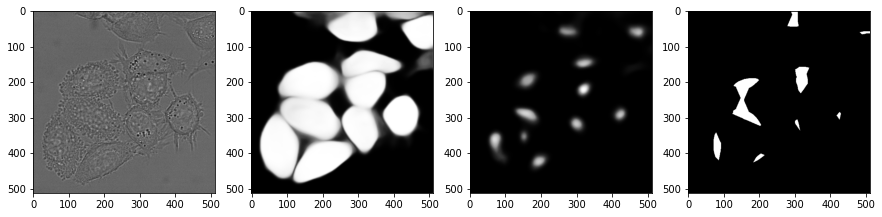

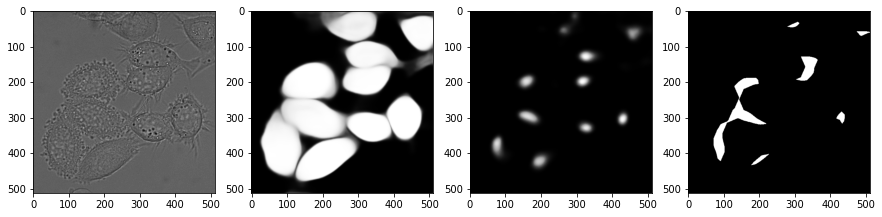

In [ ]:
img1 = cv2.imread('/content/drive/Colab/data/t000.tif',-1)
pre1 = cv2.imread('/content/drive/Colab/data/t000_predict.tif',-1)
m1 = cv2.imread('/content/drive/Colab/data/t000_marker.tif',-1)
m_color1 = cv2.imread('/content/drive/Colab/data/t000.tif')

draw1 = draw_contours(img1,pre1,m1,m_color1)

img2 = cv2.imread('/content/drive/Colab/data/DIC-C2DH-HeLa_raw/Sequence 1/t001.tif',-1)
pre2 = cv2.imread('/content/drive/Colab/predict/s1/t001_predict.tif',-1)
m2 = cv2.imread('/content/drive/Colab/predict/m1/t001_marker.tif',-1)
m_color2 = cv2.imread('/content/drive/Colab/data/DIC-C2DH-HeLa_raw/Sequence 1/t001.tif')

draw2 = draw_contours(img2,pre2,m2,m_color2)


plt.figure(figsize=(15,8))
plt.subplot(141)
plt.imshow(img1,'gray')
plt.subplot(142)
plt.imshow(pre1,'gray')
plt.subplot(143)
plt.imshow(m1,'gray')
plt.subplot(144)
plt.imshow(draw1,'gray')
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(141)
plt.imshow(img2,'gray')
plt.subplot(142)
plt.imshow(pre2,'gray')
plt.subplot(143)
plt.imshow(m2,'gray')
plt.subplot(144)
plt.imshow(draw2,'gray')
plt.show()

In [ ]:
for i in range(raw_data.shape[0]):
  img = raw_data[i]
  pre = predict_data[i]
  m = marker_data[i]
  num = 1000+i
  img_color = cv2.imread(raw_path + '/t'+ str(num)[1:] +'.tif')

  draw = draw_contours(img,pre,m,img_color)
  print("frame:",i)

  plt.figure(figsize=(15,8))
  plt.subplot(141)
  plt.imshow(img,'gray')
  plt.subplot(142)
  plt.imshow(pre,'gray')
  plt.subplot(143)
  plt.imshow(m,'gray')
  plt.subplot(144)
  plt.imshow(draw,'gray')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

save video

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage.transform as trans

image_path = '/content/drive/Colab/data/DIC-C2DH-HeLa_raw/Sequence 1'
image_data = np.asarray(list(io.ImageCollection(image_path + '/t*.tif')))

video_path = '/content/drive/Colab/video.avi'
video_fps = 10
video_size = (512,512)
video_type = cv2.VideoWriter_fourcc(*'XVID')

writer = cv2.VideoWriter(video_path, video_type, video_fps, video_size, isColor = False)
for i in range(image_data.shape[0]) :
    writer.write(image_data[i])

writer.release()
print('saved')